### [Day2]
* Day1で頂いたコメントをもとに前処理を中心に修正途中
* データの標準化を行った。
* ホールドアウト法、交差検証を用いた汎化性能の評価を行った。
* ホールドアウト法を用いることでDay1に比べ15 %程度制度が低下した一方で、交差検証ではDay1とほぼ同程度の値が出ており安定していない。精度が高すぎるような気がするため、事前の処理などを見直してみる予定です。

In [1]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from common_func import plot_decision_regions

In [2]:
#データセットのインポート
df_project=pd.read_csv("../1_data/ks-projects-201801.csv")[["deadline","launched","state","usd_pledged_real","usd_goal_real"]]

#表示
display(df_project.head(20))
df_project.describe()
df_project.info()

,deadline,launched,state,usd_pledged_real,usd_goal_real
0,2015-10-09,2015-08-11 12:12:28,failed,0.00,1533.95
1,2017-11-01,2017-09-02 04:43:57,failed,2421.00,30000.00
2,2013-02-26,2013-01-12 00:20:50,failed,220.00,45000.00
3,2012-04-16,2012-03-17 03:24:11,failed,1.00,5000.00
4,2015-08-29,2015-07-04 08:35:03,canceled,1283.00,19500.00
5,2016-04-01,2016-02-26 13:38:27,successful,52375.00,50000.00
6,2014-12-21,2014-12-01 18:30:44,successful,1205.00,1000.00
7,2016-03-17,2016-02-01 20:05:12,failed,453.00,25000.00
8,2014-05-29,2014-04-24 18:14:43,canceled,8233.00,125000.00
9,2014-08-10,2014-07-11 21:55:48,canceled,6240.57,65000.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 5 columns):
deadline            378661 non-null object
launched            378661 non-null object
state               378661 non-null object
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(2), object(3)
memory usage: 14.4+ MB


In [10]:
#stateの中身を確認
print(df_project.state.value_counts())

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [4]:
#日数計算
df_project['deadline'] = pd.to_datetime(df_project['deadline'],format='%Y-%m-%d')
df_project['launched'] = pd.to_datetime(df_project['launched'],format='%Y-%m-%d')

df_project['count'] = (df_project['deadline'] - df_project['launched']).astype('timedelta64[D]')
count = df_project['count'].value_counts()

In [5]:
display(df_project.head())

,deadline,launched,state,usd_pledged_real,usd_goal_real,count
0,2015-10-09,2015-08-11 12:12:28,failed,0.0,1533.95,58.0
1,2017-11-01,2017-09-02 04:43:57,failed,2421.0,30000.00,59.0
2,2013-02-26,2013-01-12 00:20:50,failed,220.0,45000.00,44.0
3,2012-04-16,2012-03-17 03:24:11,failed,1.0,5000.00,29.0
4,2015-08-29,2015-07-04 08:35:03,canceled,1283.0,19500.00,55.0


In [ ]:
plt.subplot(3,1,1)
plt.hist(df_project.goal, log=True)
plt.tight_layout()
plt.subplot(3,1,2)
plt.hist(df_project.pledged, log=True)
plt.subplot(3,1,3)
plt.hist(df_project.backers, log=True)

In [13]:
print(df_project.state.value_counts())

failed        197719
successful    133956
canceled       38779
                8207
Name: state, dtype: int64


In [20]:
#2値に分ける(その他の削除の仕方が不明でした。)
#df_project['state']=df_project['state'].replace(["undefined","live","suspended"],"")
df_project.loc[df_project['state'] == 'successful','state_n']=1
df_project.loc[df_project['state'] != 'successful','state_n']=0
display(df_project.head())
print(df_project.state.value_counts())
print(df_project.state_n.value_counts())

,deadline,launched,state,usd_pledged_real,usd_goal_real,count,state_n
0,2015-10-09,2015-08-11 12:12:28,failed,0.0,1533.95,58.0,0.0
1,2017-11-01,2017-09-02 04:43:57,failed,2421.0,30000.00,59.0,0.0
2,2013-02-26,2013-01-12 00:20:50,failed,220.0,45000.00,44.0,0.0
3,2012-04-16,2012-03-17 03:24:11,failed,1.0,5000.00,29.0,0.0
4,2015-08-29,2015-07-04 08:35:03,canceled,1283.0,19500.00,55.0,0.0


failed        197719
successful    133956
canceled       38779
                8207
Name: state, dtype: int64
0.0    244705
1.0    133956
Name: state_n, dtype: int64


In [21]:
#state等を削除
drop_columns = ['state','deadline','launched']
df_project = df_project.drop(drop_columns, axis = 1)

In [22]:
df_project.isnull().sum()

usd_pledged_real    0
usd_goal_real       0
count               0
state_n             0
dtype: int64

In [23]:
#ダミー変数作成
#df_project=pd.get_dummies(df_project)
#display(df_project.head())

In [24]:
#相関マップ
df_project.corr().style.background_gradient(cmap='coolwarm')
#sns.heatmap(df_project.corr(), cmap='coolwarm', vmin=-1, vmax=1

,usd_pledged_real,usd_goal_real,count,state_n
usd_pledged_real,1,0.00559611,0.000945813,0.110704
usd_goal_real,0.00559611,1,0.0041839,-0.0230518
count,0.000945813,0.0041839,1,-0.0260959
state_n,0.110704,-0.0230518,-0.0260959,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000199810D0B00>,
      dtype=object)

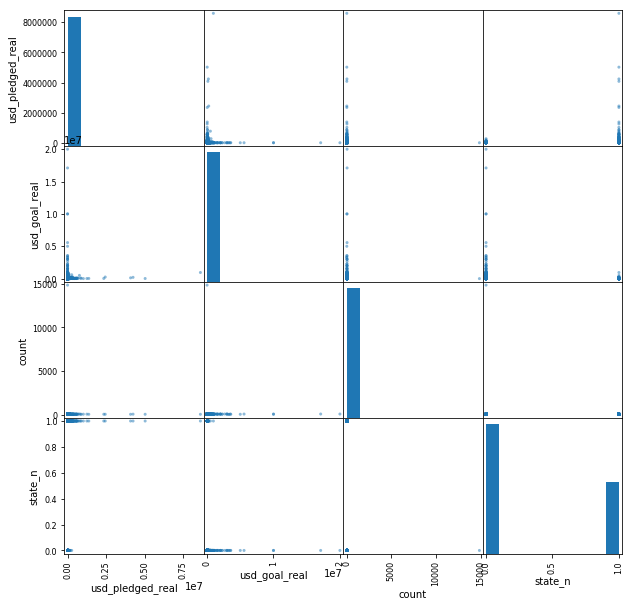

In [25]:
#散布図を作成
pd.plotting.scatter_matrix(df_project.head(10000), figsize=(10,10))

In [26]:
y = df_project["state_n"].values
X = df_project.drop('state_n', axis=1).values

In [27]:
#ホールドアウト法を使用
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

(array([7.5696e+04, 2.1000e+01, 9.0000e+00, 4.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-9.80600500e-02,  1.42144768e+01,  2.85270137e+01,  4.28395505e+01,
         5.71520874e+01,  7.14646242e+01,  8.57771611e+01,  1.00089698e+02,
         1.14402235e+02,  1.28714772e+02,  1.43027308e+02]),
 <a list of 10 Patch objects>)

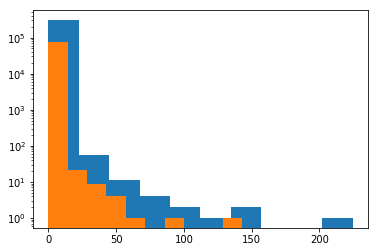

In [28]:
#標準化を実施
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
plt.hist(X_train[:, 0], log=True) 
stdsc = StandardScaler()
X_test = stdsc.fit_transform(X_test)
plt.hist(X_test[:, 0], log=True) 

In [29]:
#ロジスティック回帰を実装
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}'.format(w0, w1, w2, w3))

w0 = -2.359, w1 = 23.174, w2 = -98.708, w3 = -1.156


In [30]:
# ラベルを予測
y_est = clf.predict(X_train)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_est)))

対数尤度 = -5.916
正答率 = 82.872%


In [31]:
# ラベルを予測
y_est2 = clf.predict(X_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est2)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est2)))

対数尤度 = -4.231
正答率 = 87.749%


In [32]:
# 予測値と正解のクロス集計
conf_mat2 = pd.DataFrame(confusion_matrix(y_test, y_est2), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat2

,予測 = 失敗,予測 = 成功
正解 = 失敗,47513,1570
正解 = 成功,7708,18942


In [33]:
#交差検証法
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train, y_train)

    # 予測を実行
    y_est = clf.predict(X_test)
    y_est_t = clf.predict(X_train)

    # 対数尤度を表示
    print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))
    print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est_t)))

    # 正答率を表示
    print('正答率_test = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))
    print('正答率_train = {:.3f}%'.format(100 * accuracy_score(y_train, y_est_t)))
    
    # 予測値と正解のクロス集計
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
    display(conf_mat)
    print()


対数尤度 = -1.206
対数尤度 = -1.164
正答率_test = 96.509%
正答率_train = 96.629%


,予測 = 失敗,予測 = 成功
正解 = 失敗,48485,598
正解 = 成功,2046,24604



対数尤度 = -0.511
対数尤度 = -0.515
正答率_test = 98.521%
正答率_train = 98.508%


,予測 = 失敗,予測 = 成功
正解 = 失敗,47667,1120
正解 = 成功,0,26945



対数尤度 = -0.382
対数尤度 = -0.384
正答率_test = 98.895%
正答率_train = 98.889%


,予測 = 失敗,予測 = 成功
正解 = 失敗,48113,837
正解 = 成功,0,26782



対数尤度 = -1.002
対数尤度 = -1.058
正答率_test = 97.100%
正答率_train = 96.938%


,予測 = 失敗,予測 = 成功
正解 = 失敗,48282,547
正解 = 成功,1649,25254



対数尤度 = -0.845
対数尤度 = -0.845
正答率_test = 97.553%
正答率_train = 97.553%


,予測 = 失敗,予測 = 成功
正解 = 失敗,48455,601
正解 = 成功,1252,25424


In [ ]:
#SVM
parameters = {'kernel':['linear', 'rbf'], 'C':[1, 1]} # ここを編集する
model = SVC()
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)